# Playground

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.utils import np_utils

%matplotlib inline

image_width = 384
image_height = 384
image_depth = 1
num_classes = 3

In [2]:
# Read the data: Features and Label for 3 planes
features = pd.read_csv("input_files/W_Feature.csv") 
labels = pd.read_csv("input_files/W_Label.csv")

# Feature is the adc values
# Scale it such that each value is between 0 and 1
min_max_scaler = MinMaxScaler() 
features_scaled = min_max_scaler.fit_transform(features) 
features.loc[:,:] = features_scaled

features.head()

,Pixel 0,Pixel 1,Pixel 2,Pixel 3,Pixel 4,Pixel 5,Pixel 6,Pixel 7,Pixel 8,Pixel 9,...,Pixel 147446,Pixel 147447,Pixel 147448,Pixel 147449,Pixel 147450,Pixel 147451,Pixel 147452,Pixel 147453,Pixel 147454,Pixel 147455
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.181587,0.656629,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# Get a Numpy representation of the DataFrame
X = features.values.reshape(features.shape[0], image_width, image_height, image_depth)
print(X.shape)

y = labels.values
y = np_utils.to_categorical(y, num_classes=3)
y = y.reshape([labels.shape[0], image_width, image_height, num_classes])

print(y.shape)

(30, 384, 384, 1)


Using TensorFlow backend.


(30, 384, 384, 3)


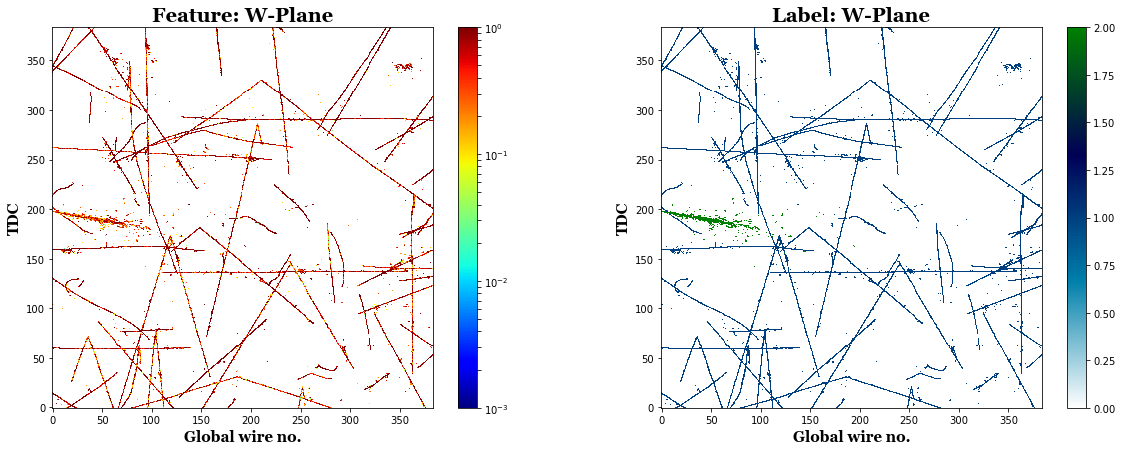

In [47]:
from matplotlib.colors import LogNorm
xImage = X.reshape(X.shape[0], image_width, image_height)
zImage = xImage[0][:,:]
yImage = labels.values.reshape(y.shape[0], image_width, image_height)
zLabel = yImage[0][:,:]

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20,7), facecolor='w')
c0 = ax0.imshow(zImage, cmap='jet',interpolation='none', origin='lower', 
                norm=LogNorm(vmin=1E-3, vmax=abs(zImage).max()))
fig.colorbar(c0, ax=ax0)
ax0.set_xlabel("Global wire no.", fontsize=15, fontname='Georgia',fontweight='bold')
ax0.set_ylabel("TDC", fontsize=15, fontname='Georgia',fontweight='bold')
ax0.set_title('Feature: W-Plane', fontsize=20,fontname='Georgia',fontweight='bold')

c1= ax1.imshow(zLabel,cmap='ocean_r',interpolation='none', origin='lower', 
               vmin=abs(zLabel).min(), vmax=abs(zLabel).max())
fig.colorbar(c1, ax=ax1)
ax1.set_xlabel("Global wire no.", fontsize=15, fontname='Georgia',fontweight='bold')
ax1.set_ylabel("TDC", fontsize=15, fontname='Georgia',fontweight='bold')
ax1.set_title('Label: W-Plane', fontsize=20, fontname='Georgia',fontweight='bold')

plt.show()
fig.savefig('plots/W-PlaneFeatureAndLabel.pdf', bbox_inches='tight')

Label values: [0 1 2]
Label counts: [4139896  276898    6886]


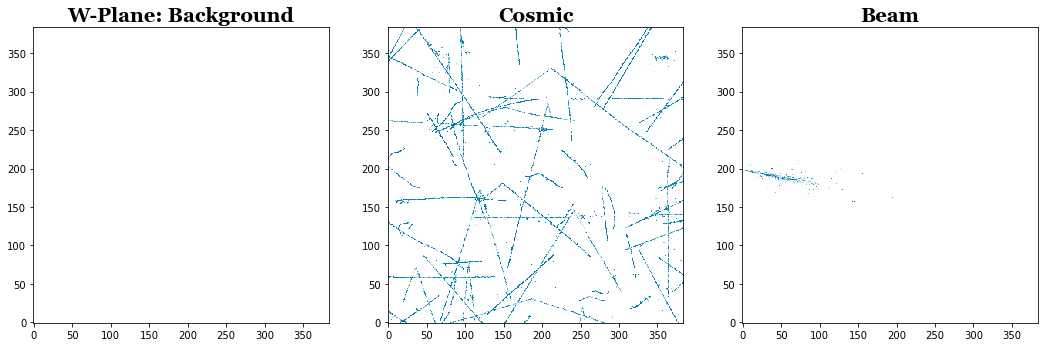

In [49]:
xImage = X.reshape(X.shape[0], image_width, image_height)
yImage = labels.values.reshape(y.shape[0], image_width, image_height)

unique_values, unique_counts = np.unique(labels.values, return_counts=True)
print('Label values:',unique_values)
print('Label counts:',unique_counts)

categories = ['W-Plane: Background','Cosmic','Beam']

fig, axes = plt.subplots(1, len(unique_values), figsize=(18,12), facecolor='w')
for index, value in enumerate(unique_values):
    ax = axes[index]
    mask = (yImage[0] == value)
    ax.imshow(xImage[0]*mask, interpolation='none', cmap='ocean_r', origin='lower',
              vmin=0., vmax=3.0)
    ax.set_title(categories[index],fontsize=20,fontname='Georgia',fontweight='bold')
plt.show()
fig.savefig('plots/W-planeBkgCosmicBeam.pdf', bbox_inches='tight')

# Build U-net model

In [50]:
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [51]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid') (c9)        

    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [81]:
import tensorflow as tf
from keras import backend as K

smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1- dice_coef(y_true, y_pred)

def soft_dice_loss(y_true, y_pred, epsilon=1e-6): 
    ''' 
    Soft dice loss calculation for arbitrary batch size, number of classes, and number of spatial dimensions.
    Assumes the `channels_last` format.
  
    # Arguments
        y_true: b x X x Y( x Z...) x c One hot encoding of ground truth
        y_pred: b x X x Y( x Z...) x c Network output, must sum to 1 over c channel (such as after softmax) 
        epsilon: Used for numerical stability to avoid divide by zero errors
    
    # References
        V-Net: Fully Convolutional Neural Networks for Volumetric Medical Image Segmentation 
        https://arxiv.org/abs/1606.04797
        More details on Dice loss formulation 
        https://mediatum.ub.tum.de/doc/1395260/1395260.pdf (page 72)
        
        Adapted from https://github.com/Lasagne/Recipes/issues/99#issuecomment-347775022
    '''
    
    # skip the batch and class axis for calculating Dice score
    axes = tuple(range(1, len(y_pred.shape)-1)) 
    numerator = 2. * np.sum(y_pred * y_true, axes)
    denominator = np.sum(np.square(y_pred) + np.square(y_true), axes)
    
    return 1 - np.mean(numerator / (denominator + epsilon)) # average over classes and batch

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec))

In [80]:
input_img = Input((image_height, image_width, 1))
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer = 'adam', 
              loss = dice_coef_loss, 
              metrics = ['accuracy', mean_iou])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 384, 384, 1)       0         
_________________________________________________________________
conv2d_115 (Conv2D)          (None, 384, 384, 16)      160       
_________________________________________________________________
batch_normalization_109 (Bat (None, 384, 384, 16)      64        
_________________________________________________________________
activation_109 (Activation)  (None, 384, 384, 16)      0         
_________________________________________________________________
conv2d_116 (Conv2D)          (None, 384, 384, 16)      2320      
_________________________________________________________________
batch_normalization_110 (Bat (None, 384, 384, 16)      64        
_________________________________________________________________
activation_110 (Activation)  (None, 384, 384, 16)      0         
__________

In [82]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('test.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [83]:
from skimage.transform import resize
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2018)

results = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))

Train on 25 samples, validate on 5 samples
Epoch 1/50
Epoch 00000: val_loss improved from inf to 0.59564, saving model to test.h5
25/25 [==============================] - 75s - loss: 0.5555 - acc: 0.4650 - mean_iou: 0.0000e+00 - val_loss: 0.5956 - val_acc: 0.6429 - val_mean_iou: 0.3841
Epoch 2/50
Epoch 00001: val_loss did not improve
25/25 [==============================] - 69s - loss: 0.5282 - acc: 0.5812 - mean_iou: 0.3809 - val_loss: 0.5961 - val_acc: 0.6687 - val_mean_iou: 0.3984
Epoch 3/50
Epoch 00002: val_loss did not improve
25/25 [==============================] - 75s - loss: 0.5099 - acc: 0.6402 - mean_iou: 0.3957 - val_loss: 0.5963 - val_acc: 0.6613 - val_mean_iou: 0.4100
Epoch 4/50
Epoch 00003: val_loss did not improve
25/25 [==============================] - 87s - loss: 0.4939 - acc: 0.6771 - mean_iou: 0.4075 - val_loss: 0.5965 - val_acc: 0.6258 - val_mean_iou: 0.4206
Epoch 5/50

Epoch 00004: reducing learning rate to 0.00010000000474974513.
Epoch 00004: val_loss did not im

In [84]:
pred = X[0].reshape(1, image_width, image_height, image_depth)

lab_pred = model.predict(pred, verbose=1)

1/1 [==============================] - 3s


In [85]:
# infer the total number of classes along with the spatial dimensions
# of the mask image via the shape of the output array
(x, height, width, numClasses) = lab_pred.shape[0:4]
print(x)
print(height)
print(width)
print(numClasses)

# our output class ID map will be num_classes x height x width in
# size, so we take the argmax to find the class label with the
# largest probability for each and every (x, y)-coordinate in the
# image
classMap = np.argmax(lab_pred[0], axis=2)
print(classMap)
# given the class ID map, we can map each of the class IDs to its
# corresponding color
#mask = COLORS[classMap]


1
384
384
3
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


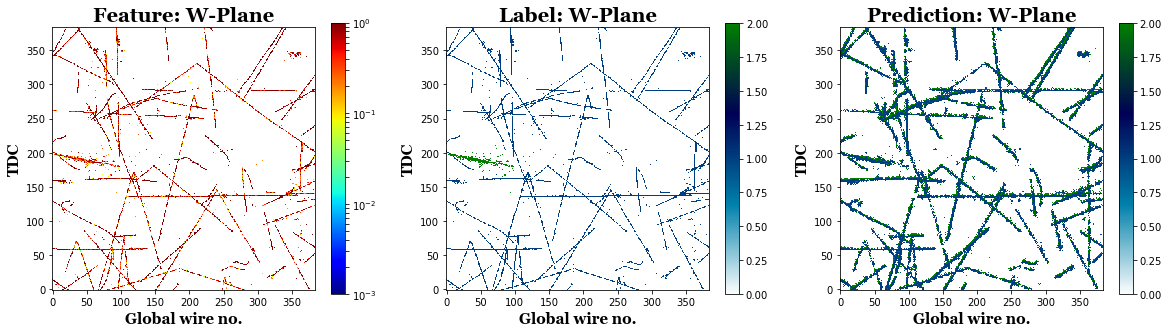

In [86]:
zPred = classMap.reshape(image_width, image_height)

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20,5), facecolor='w')
c0 = ax0.imshow(zImage, cmap='jet',interpolation='none', origin='lower', 
                norm=LogNorm(vmin=1E-3, vmax=abs(zImage).max()))
fig.colorbar(c0, ax=ax0)
ax0.set_xlabel("Global wire no.", fontsize=15, fontname='Georgia',fontweight='bold')
ax0.set_ylabel("TDC", fontsize=15, fontname='Georgia',fontweight='bold')
ax0.set_title('Feature: W-Plane', fontsize=20,fontname='Georgia',fontweight='bold')

c1= ax1.imshow(zLabel,cmap='ocean_r',interpolation='none', origin='lower', 
               vmin=abs(zLabel).min(), vmax=abs(zLabel).max())
fig.colorbar(c1, ax=ax1)
ax1.set_xlabel("Global wire no.", fontsize=15, fontname='Georgia',fontweight='bold')
ax1.set_ylabel("TDC", fontsize=15, fontname='Georgia',fontweight='bold')
ax1.set_title('Label: W-Plane', fontsize=20, fontname='Georgia',fontweight='bold')

c2= ax2.imshow(zPred, cmap='ocean_r',interpolation='none', origin='lower', 
               vmin=abs(zPred).min(), vmax=abs(zPred).max())
fig.colorbar(c2, ax=ax2)
ax2.set_xlabel("Global wire no.", fontsize=15, fontname='Georgia',fontweight='bold')
ax2.set_ylabel("TDC", fontsize=15, fontname='Georgia',fontweight='bold')
ax2.set_title('Prediction: W-Plane', fontsize=20, fontname='Georgia',fontweight='bold')

plt.show()
fig.savefig('plots/W-PlanePrediction.pdf', bbox_inches='tight')